In [39]:
# Import Basic Libraries
import numpy as np
import pandas as pd
import scipy.stats as stats

# Exploratory Analysis fo Bayesian Models
import arviz as az

# Probabilistic Programming Language
import pymc as pm

# Plottiing
import matplotlib.pyplot as plt

# Bayesian Inference - Introductory Coint Toss Example

Source: [Probabilistic Programming and Bayesian Methods for Hackers - Chapter 1](https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb)

In [40]:
# define a beta distribution
dist = stats.beta

# create a vector with different trials sizes
n_trials =[0,1,2,3,4,5,8,15,50,500]

# generate data i.e. coin tosses
data = stats.bernoulli.rvs(0.5, size =n_trials[-1])

# generate equally spaced vector as help for plotting later
x=np.linspace(0,1,100)

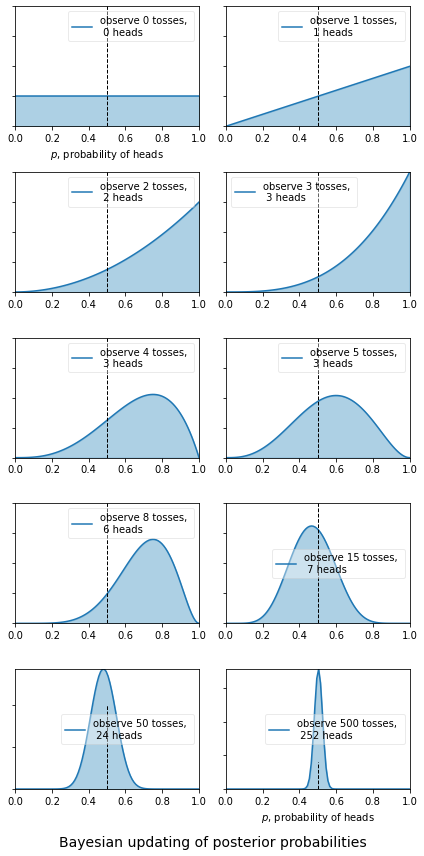

In [41]:
for k, N in enumerate(n_trials):
    # prepare plots
    sx = plt.subplot(int(len(n_trials)/2),2,k+1)
    plt.xlabel('$p$, probability of heads') \
    if k in [0,len(n_trials)-1] else None 
    plt.setp(sx.get_yticklabels(), visible=False)
    
    # number of heads observed
    heads = data[:N].sum()

    # get beta distribution over 0-1 interval for 'observed' coin tosses
    y = dist.pdf(x, 1+ heads, 1+N-heads)

    # plot the whole thing
    plt.plot(x,y,label='observe %d tosses, \n %d heads' % (N,heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)
    plt.suptitle("Bayesian updating of posterior probabilities",
                y=0,
                fontsize=14)

    plt.tight_layout(rect=(0,0,1,3))

# Introducing PYMC3 - A/B Testing Example

Source: [Probabilistic Programming and Bayesian Methods for Hackers - Chapter 2](https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb)

Assume there is some true probability $0<p_A<1>$ that users who, after being shown site A also purchase from the site. This is the true effectiveness of site A. It is currently unknown to us.

Suppose site A was shown to $N$ people and $n$ people purchased from the site. One might conclude hastily $p_A=\frac{n}{N}$. Unfortunately, the *observed frequency* $\frac{n}{N}$ does not necessarily equal $p_A$ - there is a differnce between *observed frequency* and *true frequency* of an event. The true frequency can be itnerpreted as the probability of an event ocurring. e.g. the true frequency of rolling a 1 on a 6-sided die is $\frac{1}{6}$.

The *observed frequency* is the frequency we observe: say rolling the die 100 times you may observe 20 rolls of 1. The observed frequency , $0.2$ differs from the true frequency $\frac{1}{6}$. We can use Bayesian statistics to infer probable values of the true frequency using an appropriate prior and observed data.

To setup a Bayesian model, we need to assign prior distributions to our unknown quantities. A priori, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume pA is uniform over [0,1]:

In [42]:
# In PyMC3, we typically handle all the variables we want in our model within the context of the Model object.
# Any variables created within a given Model's context will be automatically assigned to that model.
# If you try to define a variable outside of the context of a model, you will get an error.

with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

For this example consider $p_A=0.05$ and $N=1500$ users shown the site A and we will simulate wether the user made a purchase or not. To simulate this from $N$ trials, we will use a Bernoulli distribution: if $ X ~ Ber(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1-p$. Of course in practice we do not know $p_A$ but we will use it here to simulate data.

In [43]:
# set constants
p_true = 0.05 # remember, this is unkonwn!
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step

occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences)
print(np.sum(occurrences))

[0 0 0 ... 0 0 0]
76


In [44]:
# Occurrences.mean is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

What is the observed frequency in Group A? 0.0507
Does this equal the true frequency? False


In [45]:
# We can continue to work within the context of the same model by using with with the name of the model object that we have already created.
#include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    # sampling algorithm to get posterior distrubtion - more on this later
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
  

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


KeyboardInterrupt: 

<AxesSubplot:title={'center':'p'}>

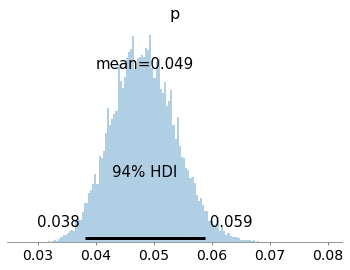

In [ ]:
# plot posterior
az.plot_posterior(trace,kind='hist')

In [ ]:
# We can examine the same variables outside of the model context once they have been defined, but to define more variables that the model will recognize they have to be within the context.

Now what we are really interested in is the *difference* between $p_A$ and $p_B$. Let's infer $p_A$, $p_B$ and $delta=p_A -p_B$ all at once. We assume for the exercise that $p_B=0.04$ so $delta=0.01$ and $N_B=750$.

In [ ]:
#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [ ]:
print(np.mean(observations_A))
print(np.mean(observations_B))

0.043333333333333335
0.036


In [ ]:
# set up the pymc3 Model. 
with pm.Model() as model:
    # Again assign uniform priors for p_A and p_B
    p_A = pm.Uniform('p_A',0,1)
    p_B = pm.Uniform('p_B',0,1)

    # Define the dterministic delta function. This is our unkown of interest.
    delta = pm.Deterministic('delta', p_A-p_B)

    # Set of observations, in this case we have to observation datasets
    obs_A = pm.Bernoulli('obs_A',p_A, observed=observations_A)
    obs_B = pm.Bernoulli('obs_B', p_B, observed = observations_B)

    step =pm.Metropolis()
    trace = pm.sample(2000, step =step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_A]
>Metropolis: [p_B]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


array([<AxesSubplot:title={'center':'p_A'}>,
       <AxesSubplot:title={'center':'p_B'}>,
       <AxesSubplot:title={'center':'delta'}>], dtype=object)

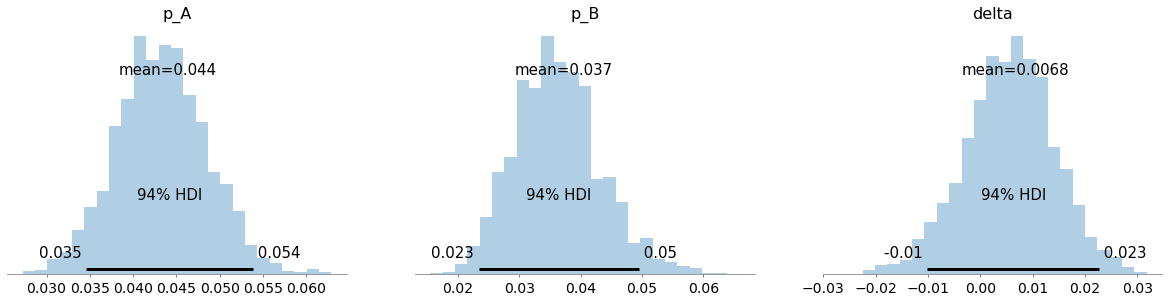

In [ ]:
# plot posterior
az.plot_posterior(trace, kind='hist', var_names =['p_A','p_B','delta'], bins=25)

In [ ]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(trace.posterior.delta < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(trace.posterior.delta> 0))

Probability site A is WORSE than site B: 0.206
Probability site A is BETTER than site B: 0.794


## Ordinal Regression

Most of this is taken from [this](https://medium.com/@liza_p_semenova/ordered-logistic-regression-and-probabilistic-programming-502d8235ad3f) tutorial. Original Code available [here](https://github.com/elizavetasemenova/PPLs/blob/master/ordered_logistic_regression/ordered_logistic_regression_PyMC3.ipynb)

In [55]:
# read dataset
df = pd.read_csv('WVS.csv')
df

,Unnamed: 0,poverty,religion,degree,country,age,gender
0,1,Too Little,yes,no,USA,44,male
1,2,About Right,yes,no,USA,40,female
2,3,Too Little,yes,no,USA,36,female
3,4,Too Much,yes,yes,USA,25,female
4,5,Too Little,yes,yes,USA,39,male
...,...,...,...,...,...,...,...
5376,5377,About Right,yes,no,Sweden,49,male
5377,5378,Too Little,yes,no,Sweden,37,female
5378,5379,Too Little,yes,no,Sweden,54,female
5379,5380,Too Little,yes,no,Sweden,32,male


In [59]:
# dictionaries to map values to categorical
dict_pov = {'Too Little':0, 'About Right': 1, 'Too Much': 2}
dict_religion = {'yes':1, 'no':0}
dict_degree = {'no':0, 'yes':1}
dict_gender = {'male':0, 'female':0}

In [60]:
df = df.replace({'poverty':dict_pov})
df = df.replace({'religion':dict_religion})
df = df.replace({'degree':dict_degree})
df = df.replace({'gender':dict_gender})

In [64]:

# standardize age
df['age'] = (df['age'] - np.mean(df['age']))/np.std(df['age'])

# save outcome in seperate variable
y = df['poverty'].values

# define covariates
X_vars = ['religion','degree','age','gender']
X = df[X_vars].values



In [65]:
N = X.shape[0]
D = X.shape[1]

In [66]:
with pm.Model() as cat_mod:

    # Priors
    sigma = pm.HalfNormal('sigma', sd = 1)   
    
    beta = pm.Normal('beta', mu=0, sd=sigma, shape=D) 
    
    lp = pm.math.dot(X, beta)
    
    cutpoints = pm.Normal("cutpoints", mu=[-0.01,0], sd=20, shape=2,
                           transform=pm.distributions.transforms.ordered)
    
    # Likelihood 
    y_obs = pm.OrderedLogistic("y_obs", eta=lp, cutpoints=cutpoints, observed=y-1)

In [67]:
with cat_mod:
    # draw posterior samples
    trace = pm.sample(5000, tune=5000, nuts_kwargs=dict(target_accept=.85))

ValueError: Unused step method arguments: {'nuts_kwargs'}

In [ ]:
pm.summary(trace).round(2)
ppc = pm.sample_ppc(trace, samples=5000, model=mod, size=1)


In [ ]:
y_pred_samps = ppc['y_obs']
y_pred = np.zeros(y_pred_samps.shape[1])

for i in range(0,len(pred)):

    p1 = np.mean(y_pred_samps[:,i] == 0)
    p2 = np.mean(y_pred_samps[:,i] == 1)
    p3 = np.mean(y_pred_samps[:,i] == 2)
    probs = [p1, p2, p3]
    
    y_pred[i] = probs.index(max(probs)) + 1

In [ ]:
confusion_matrix(y-1, y_pred-1)
round(accuracy_score(y_true=y, y_pred=y_pred),2)


## Survival Analysis

Most of this is taken from [this](https://docs.pymc.io/en/v3/pymc-examples/examples/survival_analysis/survival_analysis.html) tutorial.

In [14]:
# load dataset
df = pd.read_csv('/Users/htr365/Documents/PhD/mastectomy.csv')

In [16]:
# transform to numeric and get patient count
df.event = df.event.astype(np.int64)
df.metastized = (df.metastized =='yes').astype(np.int64)
n_patients = df.shape[0]
patients = np.arange(n_patients)

# take a look at data structure
df.head()

,time,event,metastized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0


In [27]:
n_patients

44

Survival analysis is primarily interested in the time to event $t$. 
This is usually modelled via a survival function:
$$ S(t) = P(T>t) = 1-F(t)$$

where $F$ is the Cumulative Distribution Function of $T$. The survival function is often expressed in terms of the hazard rate $\lambda(t)$. It is the probability that the event occurs at time $t$ given that it hasn't occured yet.

$$ \lambda(t) = \lim_{\Delta \rightarrow 0} \frac{P(t<T<t+\Delta t | T>t)}{\Delta t} = \lim_{\Delta \rightarrow 0} \frac{P(t<T<t+\Delta t)}{\Delta t * P(T>t)}= \frac{1}{S(t)}*\lim_{\Delta \rightarrow 0} \frac{S(t)-S(t+\Delta t)}{\Delta t} = -\frac{S'(t)}{S(t)}$$

Solving the differential equation for the survival function shows that
$$S(t) = exp( - \int_0^s \lambda(s)ds)$$

This representation of the survival function shows that the cumulative hazard function
$$\Lambda (t) = \int_0^t \lambda(s) ds$$
is an important quantity in survival analysis, since we may concisely write $S(t) = exp(-\Lambda (t))$


An important, but subtle, point in survival analysis is censoring. Even though the quantity we are interested in estimating is the time between surgery and death, we do not observe the death of every subject. At the point in time that we perform our analysis, some of our subjects will thankfully still be alive. In the case of our mastectomy study, df.event is one if the subject’s death was observed (the observation is not censored) and is zero if the death was not observed (the observation is censored).


In [29]:
df.event.mean()

0.5909090909090909

This means that just over 40% of the observations are censored.

In [22]:
0, df[df.event.values == 0].time

(0,
 3      70
 4     100
 5     101
 8     198
 9     208
 10    212
 11    224
 30     76
 31    105
 32    107
 33    109
 35    116
 38    145
 39    162
 40    188
 41    212
 42    217
 43    225
 Name: time, dtype: int64)

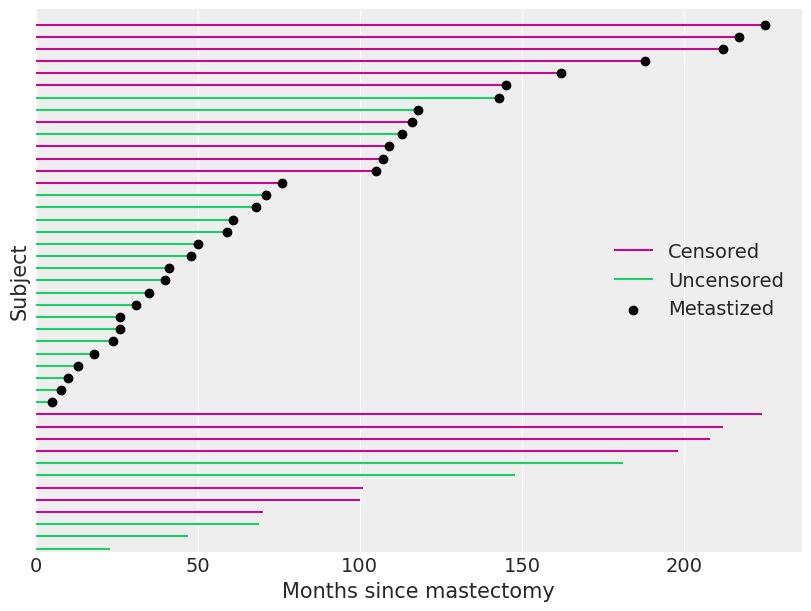

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hlines(
    patients[df.event.values == 0], 0, df[df.event.values == 0].time, color="C3", label="Censored"
)

ax.hlines(
    patients[df.event.values == 1], 0, df[df.event.values == 1].time, color="C7", label="Uncensored"
)

ax.scatter(
    df[df.metastized.values == 1].time,
    patients[df.metastized.values == 1],
    color="k",
    zorder=10,
    label="Metastized",
)

ax.set_xlim(left=0)
ax.set_xlabel("Months since mastectomy")
ax.set_yticks([])
ax.set_ylabel("Subject")

ax.set_ylim(-0.25, n_patients + 0.25)

ax.legend(loc="center right");



In this case we want to study the effect of metastization on survival time (in a social science case this could be some kind of treatment), due to that a risk regression model is most appropriate. The most common one is Cox's proportioinal hazards model. In this model the hazard rate is modelled as
$$\lambda (t) = \lambda_0 (t) exp(x \beta)$$

where $x$ are covariates and $\beta$ are the regression coefficients. $\lambda_0$ is the base hazard rate which is independent of the covariates.

In order to perform Bayesian inference we need some priors.
For $\beta$ we choose a normal prior $\beta ± N(\mu_\beta, \sigma^2_\beta)$ where $\mu_\beta ± N(0,10^2)$ and $\sigma_\beta ± U(0,10)$

It is not so obvious how to choose a prior for $\lambda_0(t)$, thus we choose a semi-parametric prior with a piecewise constant function. For that, we have to partition the time range in question into intervals with endpoints $0 \leq s_1 < s_2 < \dots <s_N$>. With this partition, $\lambda_{0(t)} = \lambda_j$ if $s_j \leq t < s_{j+1}$.